## Multi-Class Prediction of Cirrhosis Outcomes

In this Notebook we will train and deploy a Multi-Class Prediction model of Cirrhosis Outcomes. The data comes from the Kaggel Playground Series - Season 3, Episode 26

Data Citation:

Walter Reade, Ashley Chow. (2023). Multi-Class Prediction of Cirrhosis Outcomes. Kaggle. https://kaggle.com/competitions/playground-series-s3e26

## Handle to workspace

We will first create a handle to the workspace for this notebook (Note: this Notebook is designed to be run in Azure AI | Machine Learning-Studio)

In [3]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# authenticate
credential = DefaultAzureCredential()

SUBSCRIPTION = "********-****-****-****-************"
RESOURCE_GROUP = "#############"
WS_NAME = "############"
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id=SUBSCRIPTION,
    resource_group_name=RESOURCE_GROUP,
    workspace_name=WS_NAME,
)

In [ ]:
# Verify that the handle works correctly.
ws = ml_client.workspaces.get(WS_NAME)
print(ws.location, ":", ws.resource_group)

## Training script

Before training the model we will do some quick data preperation. For this the data will be shuffeled, to ensure no artifacts when splitting the data into training and test sets. In addition, row containing `NA` are droped. Most of the preprocessing, however, will be handeled in the model pipline, as this allows for raw_data to be subitted to the endpoint later.

In [24]:
import pandas as pd
raw_data = pd.read_csv("./data/train.csv")
raw_data = raw_data.sample(frac=1, random_state=112).reset_index(drop=True)
raw_data = raw_data.dropna()
raw_data.to_csv("./data/shuffeld_data.csv", index=False)

We will now write a python script which handels training our model. The model used in this notebook was devoloped during the Kaggle competition and achived the 42nd place out of 1663 submissions.

Details of model developement will not be covered in this notebook.

The training script will be saved in the folder `scripts`. It handles the preprocessing of the data and splits the training data into a test, train, and validation dataset. It then consumes this data to train an ensamble of tree based models and return the output model. The validation data will be saved, so it can be used later to test the endpoint.

Notes:
- The data in `data/test.csv` was the test data for the Kaggle competition and can be ignored in this Notebook.
- The validation split in this Notebook does not represent the "classic" validaiton split used to evaluate model preformance, as this was already done during model developement. Instead it is used to validate the function of the Azure endpoint to wich the model will be deployed.

In [5]:
import os

train_scripts_dir = "./scripts"
os.makedirs(train_scripts_dir, exist_ok=True)

In [25]:
%%writefile {train_scripts_dir}/train_model.py
import mlflow
import mlflow.sklearn
import os
import argparse
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import train_test_split

def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--n_val", required=False, default=20, type=int)
    parser.add_argument("--test_train_ratio", type=float, required=False, default=0.25)
    parser.add_argument("--registered_model_name", type=str, help="model name")
    args = parser.parse_args()
   
    # Start Logging
    mlflow.start_run()

    # enable autologging
    mlflow.sklearn.autolog()

    ###################################################################################
    # prepare data

    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

    print("input data:", args.data)
    
    raw_data = pd.read_csv(args.data)

    X = raw_data[args.n_val:]

    train_df, test_df = train_test_split(
        X,
        test_size=args.test_train_ratio,
        random_state=112
    )

    y_train = train_df['Status'].copy()
    X_train = train_df.drop(['Status'], axis=1)

    y_test = test_df['Status'].copy()
    X_test = test_df.drop(['Status'], axis=1)

    encode = LabelEncoder()
    y_train = encode.fit_transform(y_train)

    print(f"Training with data of shape {X_train.shape}")

    ###################################################################################
    # train model

    numeric_cols = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
    categorical_cols_OH = []
    categorical_cols_OE = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']

    class ETL():
        def __init__(self):
            return None

        def transform(self,X,y=None):
            X['Alk_Phos'] = X['Alk_Phos'].apply(lambda x: min(x, 4000))
            X['Prothrombin'] = X['Prothrombin'].apply(lambda x: min(x, 14))
            X['Stage'] = X['Stage'].astype(object)
            X = X.drop(['id'], axis=1)
            return X

        def fit(self, X, y=None):
            return self
        
    transformer = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('cat_OE', OrdinalEncoder(), categorical_cols_OE),
            ('cat_OH', OneHotEncoder(), categorical_cols_OH)
        ]
    )

    ETL_pipline = Pipeline(steps=[
                            ('ETL', ETL()),
                            ('transformer', transformer)
                            ])
    
    xgb_params ={'max_depth': 16,
        'learning_rate': 0.07955658827201513,
        'n_estimators': 1318,
        'subsample': 0.7469188198194912,
        'colsample_bytree': 0.023847784550319412,
        'reg_alpha': 4.251195978998175,
        'reg_lambda': 9.143539708234597,
        'random_state': 112,
        'eval_metric': 'mlogloss',
    }

    lgb_params = {
        'metric': 'multi_logloss', 
        'max_depth': 18,
        'min_child_samples': 12,
        'learning_rate': 0.019265722887208857,
        'n_estimators': 561,
        'subsample': 0.58120988528067,
        'min_child_weight': 5.3032983255619115,
        'colsample_bytree': 0.15297945002747868,
        'reg_alpha': 0.513877346112968,
        'reg_lambda': 0.26119096957757604, 
        'random_state': 112,
        'verbosity' : -1
    }

    lgbm_model = LGBMClassifier(**lgb_params)

    xgb_model = XGBClassifier(**xgb_params)

    Ensemble = VotingClassifier(estimators = [('lgb', lgbm_model), ('xgb', xgb_model)], 
                                voting='soft',
                                weights = [
                                    0.5,
                                    0.5]
                                )
    
    pipeline = Pipeline(steps=[
                            ('ETL_pipline', ETL_pipline),
                            ('model', Ensemble)
                            ])
    
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_test = encode.transform(y_test)

    print(classification_report(y_test, y_pred))

    ###################################################################################
    # Register model
    
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        registered_model_name=args.registered_model_name,
        artifact_path=args.registered_model_name,
    )

    # Saving the model to a file
    mlflow.sklearn.save_model(
        sk_model=pipeline,
        path=os.path.join(args.registered_model_name, "trained_model"),
    )
    
    # Stop Logging
    mlflow.end_run()

if __name__ == "__main__":
    main()

Overwriting ./scripts/train_model.py


Now that we have a script, which can train our model, we can configure the command which runs the script. Here, we will specify the data location, the number of data points to set aside for endpoint testing, the test to train ratio, and finally the model name. In addition, we need to specify which environmetn to use. This environment is a modefied copy of the base Azure sklearn-1.0 enfironment with the addition of xgboost (2.0.2) and lightgbm (4.1.0).

In [26]:
from azure.ai.ml import command
from azure.ai.ml import Input

registered_model_name = "prediction_of_cirrhosis_outcome"

job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            path="./data/shuffeld_data.csv",
        ),
        n_val = 10,
        test_train_ratio=0.2,
        learning_rate=0.25,
        registered_model_name=registered_model_name,
    ),
    code="./scripts/",
    command="python train_model.py --data ${{inputs.data}} --n_val ${{inputs.n_val}} --test_train_ratio ${{inputs.test_train_ratio}} --registered_model_name ${{inputs.registered_model_name}}",
    environment="portfolio_proj:1",
    display_name="prediction_of_cirrhosis_outcome",
)

We will now submitt this job and can view the job output

In [ ]:
ml_client.create_or_update(job)

## Deploy model to endpoint

In order ot deploy our model to an endpoint, we will first create a unique name and then create the desired endpoint

In [31]:
import uuid

# Creating a unique name for the endpoint
online_endpoint_name = "cirrhosis-endpoint-" + str(uuid.uuid4())[:8]

In [32]:
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
)

endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="this is an online endpoint",
    auth_mode="key",
    tags={
        "training_dataset": "cirrhosis-outcome",
        "model_type": "ensamble",
    },
)

endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint).result()

print(f"Endpoint {endpoint.name} provisioning state: {endpoint.provisioning_state}")

Endpoint cirrhosis-endpoint-79eafc8d provisioning state: Succeeded


We can now load the latest model version and deploy it to the endpoint

In [33]:
latest_model_version = max(
    [int(m.version) for m in ml_client.models.list(name=registered_model_name)]
)
print(f'Latest model is version "{latest_model_version}" ')

Latest model is version "1" 


In [34]:
# picking the latest model version to deploy.
model = ml_client.models.get(name=registered_model_name, version=latest_model_version)

blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=online_endpoint_name,
    model=model,
    instance_type="Standard_D2a_v4",
    instance_count=1,
)

blue_deployment = ml_client.begin_create_or_update(blue_deployment).result()

Check: endpoint cirrhosis-endpoint-79eafc8d exists


...................................................................................................

## Submitt query to enpoint

In order to submitt a query to the enpoint, we will first generate a file as the is expected by the endpoint. For this we will use the data 10 data points we set aside earlier.

In [85]:
import json

n_val = 10

raw_data = pd.read_csv("./data/shuffeld_data.csv")

val_data_endpoint = raw_data[0:n_val]
val_data_endpoint_y = val_data_endpoint['Status'].copy()
val_data_endpoint_X = val_data_endpoint.drop(['Status'], axis=1)

result = {
    "input_data": {
        "columns": list(val_data_endpoint_X.columns),
        "index": list(val_data_endpoint_X.index),
        "data": val_data_endpoint_X.values.tolist()
    }
}

with open("./data/val_data_endpoint_X.json", "w") as f:
    json.dump(result, f, indent=4)

After saving the data into a json file, we cann invoke the endpoint and get predictions on the sample data. In addition, we will decode the data into its original format.

In [ ]:
import ast

def decode(output: str):
    mapping = {0: 'C',1: 'CL', 2: 'D'}

    lst_output = ast.literal_eval(output)
    return [mapping[item] for item in lst_output]

In [86]:
y_val_pred = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    request_file="./data/val_data_endpoint_X.json",
    deployment_name="blue",
)

y_val_pred = decode(y_val_pred)

We decode this data into the original format, after which we can compare the results to the ture lables.

In [89]:
y_val_true = val_data_endpoint_y
y_val_true = y_val_true.to_list()

Compare predicted to actual values

Note: The confusion matrix only has the dimesion 2x2, because the sample data didn't contain the lable "CL"

In [96]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


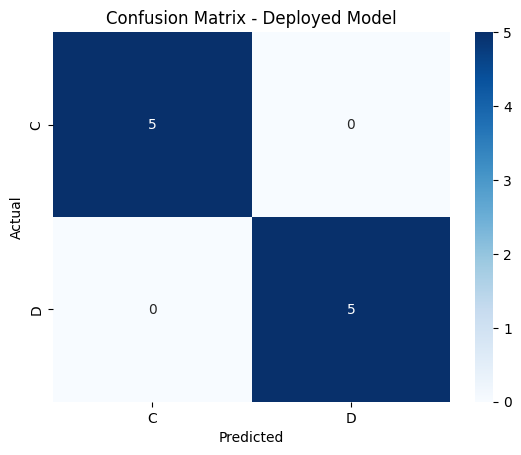

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

sns.heatmap(pd.DataFrame(confusion_matrix(y_val_true, y_val_pred), index= range(2), columns = range(2)),
            cmap='Blues', annot = True, fmt='d', xticklabels=['C', 'D'], yticklabels=['C', 'D'])
plt.title('Confusion Matrix - Deployed Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Delete endpoint

As a final part of this notebook, we will delete the endpoint so no compute resources are wasted.

In [97]:
ml_client.online_endpoints.begin_delete(name=online_endpoint_name)

................